In [ ]:
# This file aims to display some functions regarding Brightway 2.5, to demonstrate what can be done with the software when you have a foreground model matched with ecoinvent's bio- and technosphere.

# Analysis

### 1. Loading the project

In [2]:
# basic imports from brightway
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
from bw2io.importers import SingleOutputEcospold2Importer
import bw2analyzer as bwa
from bw2data import methods

# other relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

15:34:02+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


In [3]:
# define a project where we install the databases and work in this script
bd.projects.set_current('brightway25')

### 2. Database overview

In [4]:
bd.databases

Databases dictionary with 4 object(s):
	biosphere3
	bw25_db
	ecoinvent-3.10-biosphere
	ecoinvent310clca

In [5]:
bd.projects.current

'brightway25'

In [6]:
ei_clca = bd.Database('ecoinvent310clca')
ei_bio = bd.Database('ecoinvent-3.10-biosphere')
db_template = bd.Database('bw25_db')
el_bio3 = bd.Database('biosphere3')

### 3. Database exploration

In [ ]:
db_template.search('ceramics')

In [7]:
ei_clca.search('smartphone')

['consumer electronics production, mobile device, smartphone' (unit, GLO, None),
 'treatment of used smartphone, mechanical treatment' (kilogram, GLO, None),
 'market for power adapter, for smartphone' (unit, GLO, None),
 'market for consumer electronics, mobile device, smartphone' (unit, GLO, None),
 'market for used smartphone' (kilogram, GLO, None),
 'power adapter production, for smartphone' (unit, GLO, None),
 'electronic component production, passive, mobile, earpiece and speaker' (kilogram, GLO, None),
 'liquid crystal display production, unmounted, mobile device' (kilogram, GLO, None),
 'consumer electronics production, mobile device, tablet' (unit, GLO, None),
 'printed wiring board production, mounted mainboard, mobile device, double-sided, Pb free' (square meter, GLO, None)]

In [8]:
# define a process as object in the project
ceramics = db_template.get(name = 'porcelain ceramics production', location = "RER", unit = 'kilogram')
smartphone = ei_clca.get(name = 'consumer electronics production, mobile device, smartphone', location = "GLO", unit = 'unit')


In [10]:
# quickly print all exchanges of the process defined above, sorted by amount (large to small)
exchanges = sorted(smartphone.exchanges(), key=lambda exc: exc['amount'], reverse=True)
for exc in exchanges:
    print(exc)

Exchange: 81.0739200457627 kilogram 'market group for tap water' (kilogram, GLO, None) to 'consumer electronics production, mobile device, smartphone' (unit, GLO, None)>
Exchange: 1.0 unit 'consumer electronics production, mobile device, smartphone' (unit, GLO, None) to 'consumer electronics production, mobile device, smartphone' (unit, GLO, None)>
Exchange: 1.0 unit 'market for power adapter, for smartphone' (unit, GLO, None) to 'consumer electronics production, mobile device, smartphone' (unit, GLO, None)>
Exchange: 0.44 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, GLO, None) to 'consumer electronics production, mobile device, smartphone' (unit, GLO, None)>
Exchange: 0.153230769230769 meter 'market for cable, connector for computer, without plugs' (meter, GLO, None) to 'consumer electronics production, mobile device, smartphone' (unit, GLO, None)>
Exchange: 0.0547008547008547 unit 'market for plug, inlet and outlet, for computer cable' (unit, GLO, None

### 4. Impact assessment methods

In [ ]:
# here we will analyse the set of methods that are available as part of the background
list(bd.methods)[:5]

In [ ]:
# printing all methods that contain a specific keyword, e.g. "climate change"
climate_methods = [m for m in bd.methods if any("climate change" in str(part).lower() for part in m)]
for method in climate_methods:
    print(method)

In [12]:
# selecting the impact assessment methods that we want to use in our analysis
lcia_gwp100 = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')
lcia_water = ('EF v3.1','water use','user deprivation potential (deprivation-weighted water consumption)')
lcia_land = ('EF v3.1', 'land use', 'soil quality index')

### 4. LCI 

In [ ]:
# export the LCI to e
bi.export.excel.write_lci_excel(db_template.name,
                                objs=[ceramics],
                                dirpath=Path.cwd())

### 5. LCIA

In [13]:
# Quick LCIA calculation
smartphone_lca = smartphone.lca(lcia_gwp100)
smartphone_lca.score


37.61836396506968

### 6. Contribution analysis

In [14]:
# One option to do a contribution analysis is to use the recursive calculation method
bwa.print_recursive_calculation(smartphone,
lcia_method=lcia_gwp100,max_level=3,cutoff=0.05)

Fraction of score | Absolute score | Amount | Activity
0001 | 37.62 |     1 | 'consumer electronics production, mobile device, smartphone' (unit, GLO, None)
  0.129 | 4.844 | 0.04563 | 'market for liquid crystal display, unmounted, mobile device' (kilogram, GLO, None)
    0.129 | 4.839 | 0.04563 | 'liquid crystal display production, unmounted, mobile device' (kilogram, GLO, None)
      0.0709 | 2.669 | 4.315 | 'market group for electricity, medium voltage' (kilowatt hour, GLO, None)
  0.0877 | 3.299 |     1 | 'market for power adapter, for smartphone' (unit, GLO, None)
    0.0876 | 3.295 |     1 | 'power adapter production, for smartphone' (unit, GLO, None)
  0.74 | 27.83 | 0.002958 | 'market for printed wiring board, mounted mainboard, mobile device, double-sided, Pb free' (square met
    0.74 | 27.83 | 0.002958 | 'printed wiring board production, mounted mainboard, mobile device, double-sided, Pb free' (square m
      0.678 | 25.49 | 0.0009209 | 'market for wafer, fabricated, for int

In [16]:
# Another option is to use the recursive calculation to an object, which returns a DataFrame
smartphone_ca_gwp = bwa.utils.recursive_calculation_to_object(smartphone,
                                          lcia_method=lcia_gwp100,
                                          max_level=1,
                                          cutoff=0.02,
                                          as_dataframe=True,
                                          )
smartphone_ca_gwp

,label,parent,score,fraction,amount,name,key
0,root,None,37.618364,1.000000,1.000000,"consumer electronics production, mobile device...","(ecoinvent310clca, 81b1261c4390eccaba4f6a3bd1e..."
1,root_a,root,0.833467,0.022156,0.038600,"market for battery, Li-ion, NCA, rechargeable,...","(ecoinvent310clca, 0eac769618da0c069731991238a..."
2,root_p,root,4.843835,0.128763,0.045630,"market for liquid crystal display, unmounted, ...","(ecoinvent310clca, 386ff8d67353229fc7c677f3f56..."
3,root_v,root,3.298918,0.087694,1.000000,"market for power adapter, for smartphone","(ecoinvent310clca, 64454f11844724c88ff093788e4..."
4,root_w,root,27.827572,0.739734,0.002958,"market for printed wiring board, mounted mainb...","(ecoinvent310clca, f848d3037bdacb2c97fb0683a68..."


In [17]:
# Elementary flows contribution analysis by process
smartphone_lca.to_dataframe().pivot_table(index=['col_name', 'row_name'], values='amount', aggfunc='sum').sort_values(by='amount', ascending=False)

,,amount
col_name,row_name,
"electricity production, hard coal","Carbon dioxide, fossil",9.790533
"heat and power co-generation, natural gas, combined cycle power plant, 400MW electrical","Carbon dioxide, fossil",6.357821
"electricity production, lignite","Carbon dioxide, fossil",3.968893
"electricity production, natural gas, combined cycle power plant","Carbon dioxide, fossil",3.251080
"heat and power co-generation, natural gas, 200kW electrical, lean burn","Carbon dioxide, fossil",1.966277
...,...,...
"electricity production, oil","Carbon dioxide, fossil",0.022543
"market for electricity, high voltage, cobalt industry",Dinitrogen monoxide,-0.031791
"market for electricity, medium voltage, cobalt industry",Sulfur hexafluoride,-0.090093


In [18]:
# Elementary flows contribution analysis as summary table
smartphone_lca.to_dataframe().pivot_table(index='row_name',values='amount',aggfunc='sum')

,amount
row_name,
"Carbon dioxide, fossil",30.226028
Dinitrogen monoxide,0.067706
Hexafluoroethane,1.407902
"Methane, fossil",3.071459
Sulfur hexafluoride,-0.057984
Trifluoromethane,0.033163


### 7. Plot Contribution analysis graphs

In [20]:
# Filter out the parent processes that are not relevant for the contribution analysis
smartphone_ca_gwp = smartphone_ca_gwp.dropna(subset='parent') 



C:\Users\TimWeber\AppData\Local\Temp\ipykernel_13904\1074658361.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


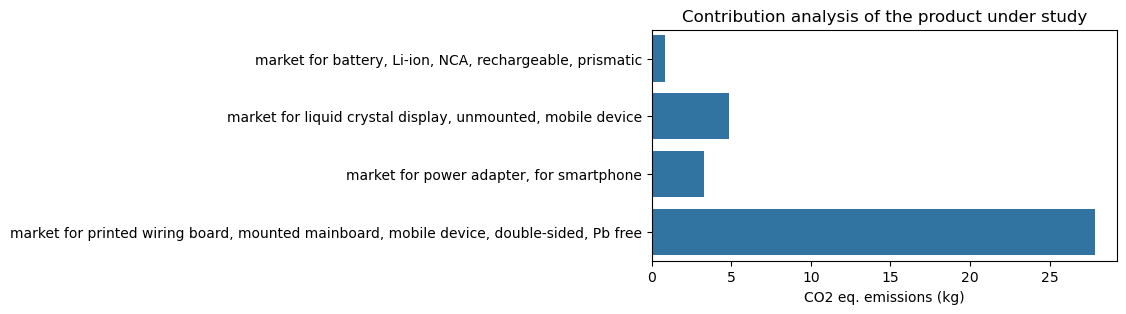

In [21]:
f, ax = plt.subplots(figsize=(6, 3))
sns.barplot(y='name', x='score', data=smartphone_ca_gwp, ax=ax)
ax.set(
    title='Contribution analysis of the product under study',
    xlabel='CO2 eq. emissions (kg)',
    ylabel='')
plt.tight_layout()
plt.show()
